# Template code for CNN

In this notebook, we will show a simple usage of CNN on the MNIST dataset. 
The usage of GPUs is highly recommended

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from math import floor

# Set torch seed
torch.manual_seed(0)

## Even before...

Be sure you have understood what happens here!

In [2]:
C_in = 3
C_out = 4
H = 5
W = 5
d = 2
bias_flag = False

X = torch.randint(0, 10, (C_in,H , W), dtype=torch.float32)
f = torch.nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=d, bias=bias_flag)
Y = f(X)
print(Y.shape)
for x in f.parameters():
    print(x)

torch.Size([4, 4, 4])
Parameter containing:
tensor([[[[ 0.2547,  0.0575],
          [-0.2510,  0.0266]],

         [[-0.1806, -0.2690],
          [ 0.2565,  0.2195]],

         [[-0.2880,  0.0540],
          [-0.0486, -0.0475]]],


        [[[-0.1321,  0.1110],
          [-0.1710,  0.1058]],

         [[ 0.1460,  0.2067],
          [ 0.1079, -0.2857]],

         [[-0.1873,  0.1441],
          [ 0.0604, -0.2252]]],


        [[[-0.1662,  0.2716],
          [ 0.1945, -0.1259]],

         [[-0.0727, -0.2750],
          [-0.0052, -0.2174]],

         [[-0.2227, -0.0159],
          [ 0.0433, -0.1182]]],


        [[[ 0.1713, -0.1757],
          [ 0.2619,  0.1978]],

         [[-0.2434, -0.0718],
          [ 0.0130,  0.0421]],

         [[ 0.0685,  0.1133],
          [ 0.0173, -0.1409]]]], requires_grad=True)


## Dataset
First, we load the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) directly from PyTorch. As usual, we split data within train, evaluation and test. Then, we create the `Dataloader` object

In [ ]:
dataset_train = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor()) # download = True just once
dataset_test = datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())

dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
print("We have", len(dataset_validation), "items for validation and", len(dataset_test), "items for test")

batch_size = 32 # Reduce it in case you need it

train_loader = DataLoader(dataset_train, batch_size=batch_size)
validation_loader = DataLoader(dataset_validation, batch_size=len(dataset_validation))
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test))

print(train_loader)

100.0%
100.0%
100.0%
100.0%

We have 5000 items for validation and 5000 items for test


## Model

Define a simple Convolutional neural network having 3 conv + pool layers. As activation function, use ReLu

In [4]:
def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    See here https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        h_out, w_out = out_dimensions(self.conv1, 28, 28)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = h_out // 2, w_out // 2
        self.dropout1 = nn.Dropout2d(p=0.3)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = h_out // 2, w_out // 2
        self.dropout2 = nn.Dropout2d(p=0.4)

        self.fc1 = nn.Linear(64 * h_out * w_out, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout_fc = nn.Dropout(p=0.5)

        self.dimensions_final = (64, h_out, w_out)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

## Training

In [5]:
model = CNN()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

Working on cuda


In [7]:
n_epochs = 5
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    for data, target in train_loader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(train_loader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validation_loader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Epoch 1: Train loss: 0.2698506875193367, Validation loss 0.05525416135787964
Epoch 2: Train loss: 0.10629679057837929, Validation loss 0.040875520557165146
Epoch 3: Train loss: 0.08443934873716595, Validation loss 0.027807865291833878
Epoch 4: Train loss: 0.07199403819222158, Validation loss 0.025356560945510864
Epoch 5: Train loss: 0.06605232128421581, Validation loss 0.02719891630113125


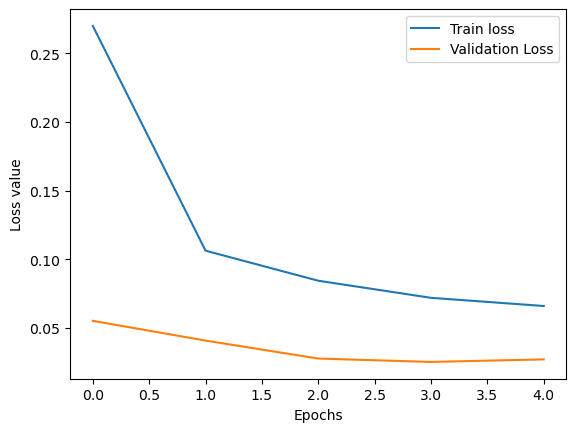

: 

In [ ]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

## Test

In this section, we test our model on new data by computing the accuracy

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")